Index(['time(s)', 'iter', 'infeas_primal', 'infeas_dual',
       'ot_objective_primal', 'ot_objective_dual', 'primal', 'dual', 'solver',
       'problem_1', 'problem_2', 'eta', 'problemclass', 'resolution',
       'ot_distance', 'unnorm_ot_distance', 'gap', 'gap_obj'],
      dtype='object')


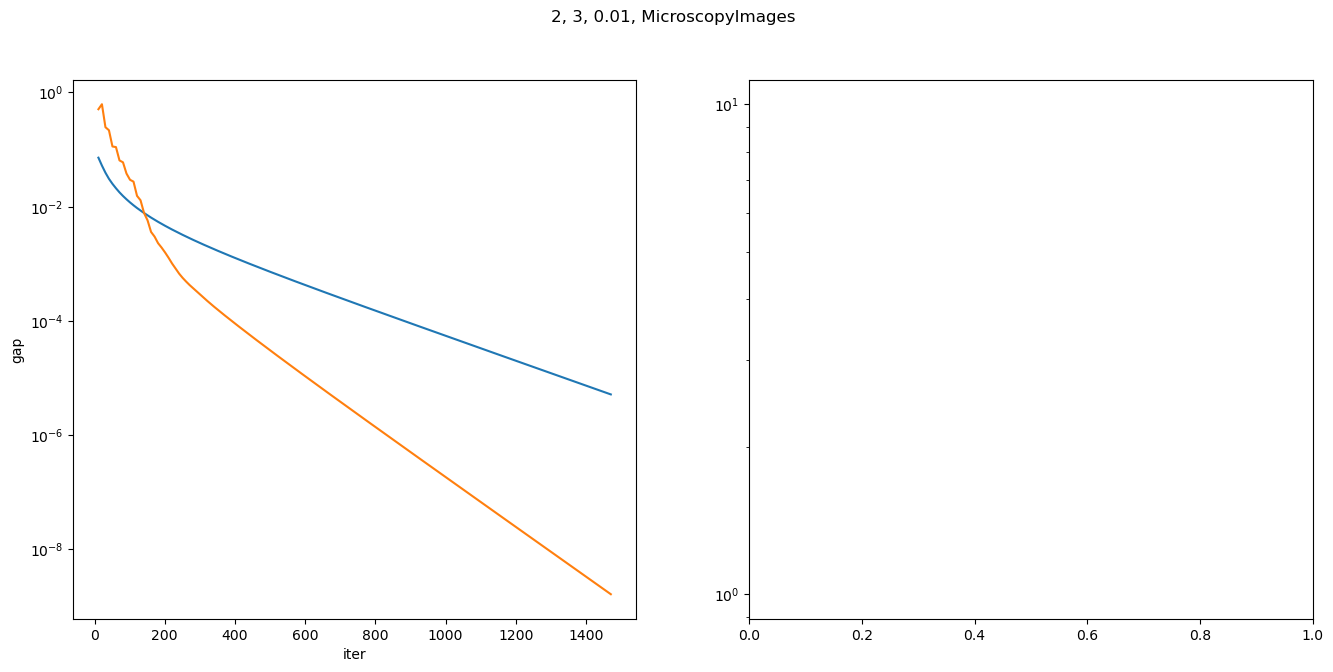

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from glob import glob
import os

def read_df(path):
    eta = 1e-2 if 'reg' in path else 1e-6
    problem_1, picture_2 = map(int, re.findall(r'(\d+)_(\d+)(?:_reg){0,1}(?:_ms){0,1}\.csv', path)[0])
    df = pd.read_csv(path, on_bad_lines='skip')
    df['problem_1'] = problem_1
    df['problem_2'] = picture_2
    df['eta'] = eta
    df['problemclass'] = 'ClassicImages' if '_ms' not in path else "MicroscopyImages"
    df = df.drop(index=[0])
    return df
df =pd.concat(map(read_df, 
                  ['data_pd_comparison_32_02_03_reg_ms.csv']#glob('data_pd_comparison*')
                  )).reset_index(drop=True)
objdf = df.melt(value_name='Objective', value_vars=['ot_objective_primal', 'ot_objective_dual'], id_vars=['iter', 'problem_1', 'problem_2', 'eta', 'problemclass'])
feasdf = df.melt(value_name='Residual', value_vars=['infeas_primal', 'infeas_dual'], id_vars=['iter', 'problem_1', 'problem_2', 'eta', 'problemclass'])
feasdf['variable'] = feasdf['variable'].replace(
    {'infeas_primal': 'Primal', 'infeas_dual': 'Dual'})
objdf['variable'] = objdf['variable'].replace(
    {'ot_objective_primal': 'Primal', 'ot_objective_dual': 'Dual'})
plt_df = objdf.merge(feasdf, on=['iter', 'variable','problem_1', 'problem_2', 'eta', 'problemclass'])
best_df = pd.read_csv(os.environ['DATA'] + "/icml_eot/ground_truths.csv")
plt_df = plt_df.merge(best_df.query('resolution==32'), on=['problem_1', 'problem_2',  'problemclass'])
df = df.merge(best_df.query('resolution==32'), on=['problem_1', 'problem_2',  'problemclass'])
plt_df['gap'] = np.abs(plt_df['Objective'] - plt_df['ot_distance'])
df['gap'] = np.abs(df['ot_objective_primal'] - 6.09339073436854e-02)
df['gap_obj'] = np.abs(df['ot_objective_primal'] - df['ot_objective_dual'])
print(df.columns)
df['pd_gap'] = np.abs(df['primal'] - df['dual'])
for (problem_1, picture_2, eta, probcls), sdf in df.groupby(['problem_1', 'problem_2', 'eta', 'problemclass']):
    fig, ax = plt.subplots(figsize=(16, 7), ncols=2)
    sns.lineplot(ax=ax[0], data=sdf, x='iter', y='gap')
    sns.lineplot(ax=ax[0], data=sdf, x='iter', y='pd_gap')
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    fig.suptitle(f"{problem_1}, {picture_2}, {eta}, {probcls}")
    # ax[0].set_ylim(ax[1].get_ylim())
    plt.show()

In [2]:
import ot
import numpy as np
import torch
W = np.loadtxt("matrix.txt")
c = np.transpose(np.loadtxt("dists.txt"))

r=ot.bregman.barycenter(A=c, M=W, method='sinkhorn_log', reg=0.01, numItermax=100000, verbose=True)
r

    1|4.019058e-02|


array([0.00205565, 0.00172804, 0.00276068, 0.00156431, 0.0030389 ,
       0.00232255, 0.00417543, 0.0030189 , 0.00213452, 0.00249583,
       0.00313197, 0.00276433, 0.00177144, 0.00176651, 0.00343215,
       0.00140979, 0.00281574, 0.00104091, 0.00117819, 0.00229156,
       0.0025169 , 0.00195203, 0.00258098, 0.00249141, 0.00154267,
       0.00314126, 0.00272742, 0.00187663, 0.00339674, 0.00328738,
       0.00244589, 0.001663  , 0.00235756, 0.00406333, 0.00100748,
       0.00232417, 0.00087767, 0.00224464, 0.00287189, 0.00367961,
       0.00429928, 0.00430064, 0.00199307, 0.00218249, 0.00245745,
       0.00295571, 0.00143806, 0.0030217 , 0.00506568, 0.00143466,
       0.00173221, 0.00258065, 0.00261288, 0.00164323, 0.00243243,
       0.00437005, 0.00241036, 0.00222065, 0.00334237, 0.00406503,
       0.00255479, 0.00253285, 0.00288585, 0.00385108, 0.0032829 ,
       0.00208984, 0.00317255, 0.00318098, 0.00211537, 0.0024247 ,
       0.00203355, 0.0028889 , 0.00173321, 0.00356023, 0.00225

In [ ]:
c.min()

In [27]:
rtest = np.loadtxt("rtest.txt")
sum(ot.emd2(rtest, c[:, i], W) for i in range(6)), sum(ot.emd2(r, c[:, i], W) for i in range(6))

(0.019392439598832883, 0.04078886223790741)

In [1]:
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt

libpath = os.environ["BENCH"] + "/DOTmark_1.0/Data/Shapes/"
c1 = pd.read_csv(libpath + "data32_1004.csv", header=None).to_numpy().astype(float)
c2 = pd.read_csv(libpath + "data32_1007.csv", header=None).to_numpy().astype(float)
# c1 = pd.read_csv(libpath + "data64_1004.csv", header=None).to_numpy()
c3 = pd.read_csv(libpath + "data32_1008.csv", header=None).to_numpy().astype(float)
c1 /= c1.max()
c2 /= c2.max()
c3 /= c3.max()
r1 = c1 / c1.sum()
r2 = c2 / c2.sum()
r3 = c3 / c3.sum()
W = np.zeros((1024, 1024))


fig, ax = plt.subplots(figsize=(8,8))
cmap = sns.color_palette("light:k_r", as_cmap=True)
sns.heatmap(c1, cmap=cmap, cbar=False, ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(c2, cmap=cmap, cbar=False, ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(c3, cmap=cmap, cbar=False, ax=ax)
plt.show()


NameError: name 'np' is not defined

In [19]:

import torch
r1 = c1.reshape(1024)+ 1e-6
r2 = c2.reshape(1024) + 1e-6
r3 = c3.reshape(1024)  + 1e-6
r1 /= r1.sum()
r2 /= r2.sum()
r3 /= r3.sum()
def euclidean_distance(ind, h):
    ind1 = ind // (h*h)
    ind2 = ind % (h*h)
    i1 = ind1 // (h)
    j1 = ind1 % (h)
    i2 = ind2 // (h)
    j2 = ind2 % (h)
    return (i1 - i2)**2 + (j1 - j2)**2
euclidean_distance = np.vectorize(euclidean_distance)
W = euclidean_distance(np.arange(1024*1024), 32).astype(float)
W = W.reshape(1024,1024)
W /= W.max()
R = torch.tensor(np.column_stack([r1, r2, r3]), device='cuda')
rmean = ot.barycenter(R, torch.tensor(W, device='cuda'), 1e-3, numItermax=1000000, stopThr = 1e-7,verbose=True)


    1|2.682795e-01|
   11|1.634286e-01|
   21|1.353594e-01|
   31|1.136119e-01|
   41|9.585613e-02|
   51|8.106359e-02|
   61|6.862539e-02|
   71|5.810769e-02|
   81|4.919932e-02|
   91|4.165358e-02|
  101|3.525996e-02|
  111|2.984062e-02|
  121|2.524724e-02|
  131|2.135539e-02|
  141|1.805960e-02|
  151|1.526989e-02|
  161|1.290948e-02|
  171|1.091289e-02|
  181|9.224432e-03|
  191|7.796801e-03|
  201|6.589866e-03|
  211|5.569616e-03|
  221|4.707244e-03|
  231|3.978363e-03|
  241|3.362339e-03|
  251|2.841715e-03|
  261|2.401727e-03|
  271|2.029890e-03|
  281|1.715651e-03|
  291|1.450088e-03|
  301|1.225659e-03|
  311|1.035991e-03|
  321|8.756977e-04|
  331|7.402274e-04|
  341|6.257335e-04|
  351|5.289657e-04|
  361|4.471775e-04|
  371|3.780483e-04|
  381|3.196169e-04|
  391|2.702264e-04|
  401|2.284765e-04|
  411|1.931841e-04|
  421|1.633494e-04|
  431|1.381275e-04|
  441|1.168045e-04|
  451|9.877696e-05|
  461|8.353507e-05|
  471|7.064788e-05|
  481|5.975121e-05|
  491|5.053725e-05|


In [20]:
rmean

tensor([9.0696e-10, 1.7485e-09, 6.1228e-09,  ..., 1.5375e-09, 1.5897e-09,
        1.3228e-09], device='cuda:0', dtype=torch.float64)

<Axes: >

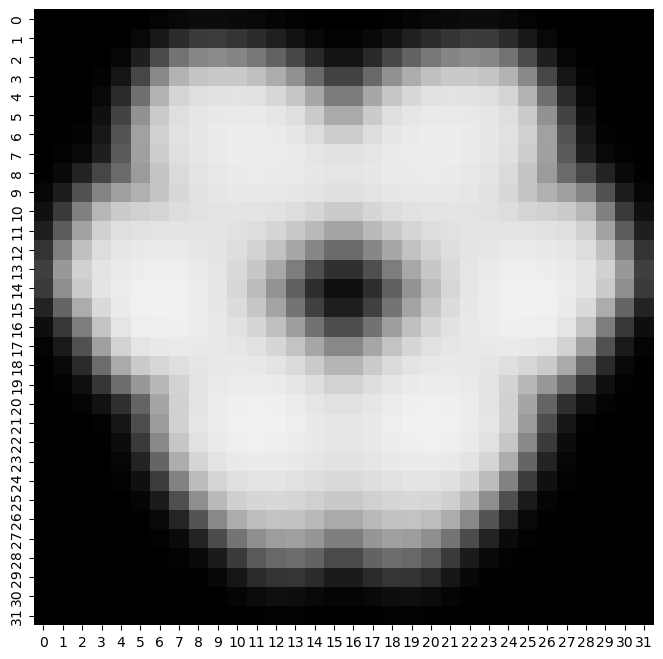

In [21]:
# rv = np.reshape(np.loadtxt("r.txt"), (64, 64)).T
# rv /= rv.max()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(rmean.cpu().reshape(32,32), cmap=cmap, cbar=False,ax=ax)


In [47]:
rv = np.loadtxt("r32.txt")


np.float64(1.0)

In [80]:
rv = np.reshape(np.loadtxt("r64.txt"), (64, 64)).T.flatten()
emdv1 = ot.emd2(rv, r1, W, numItermax=1000000) + ot.emd2(rv, r2, W, numItermax=1000000) + ot.emd2(rv, r3, W, numItermax=1000000)
emdv2 = ot.emd2(rmean.cpu().numpy(), r1, W, numItermax=1000000) + ot.emd2(rmean.cpu().numpy(), r2, W, numItermax=1000000) + ot.emd2(rmean.cpu().numpy(), r3, W, numItermax=1000000)
emdv1, emdv2

(0.667793035313321, 1.0886726451176676)

<Axes: >

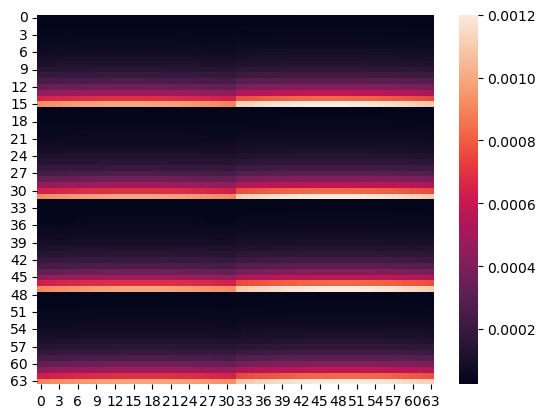

In [84]:
rv = np.reshape(np.loadtxt("r64.txt"), (64, 64)).T.flatten()

sns.heatmap(rmean.cpu().reshape(64,64))

<Axes: >

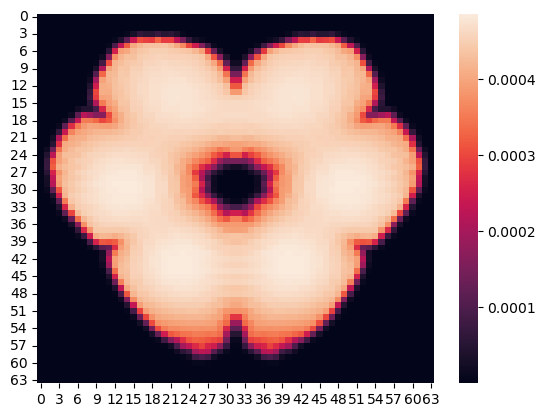

In [71]:
rv = np.reshape(np.loadtxt("r64.txt"), (64, 64)).T.flatten()

sns.heatmap(rv.reshape(64,64))

<Axes: >

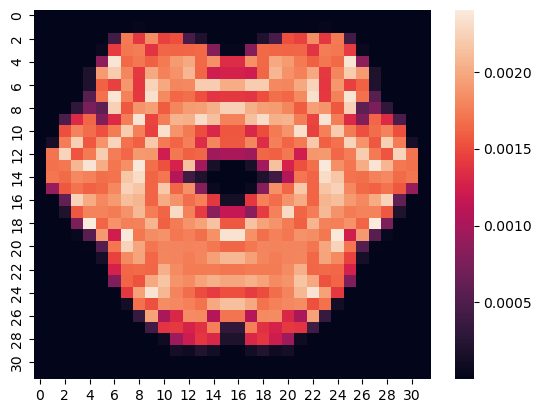

In [60]:
sns.heatmap(rv.reshape(32,32))

<Axes: >

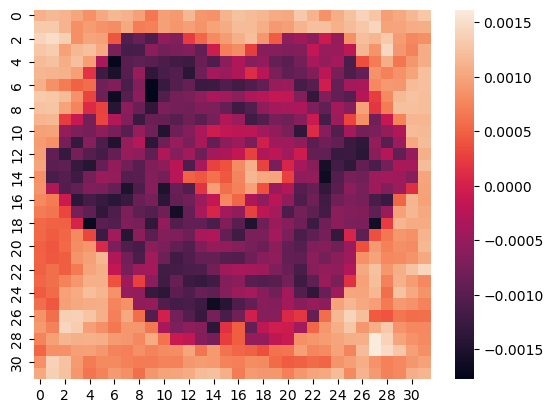

In [59]:

diff = rmean.T.cpu().numpy().reshape(1024)-rv.reshape(1024)
sns.heatmap(diff.reshape(32,32))

In [ ]:
import numpy as np
psi1 = np.loadtxt("potentials.txt.col")
psi2 = np.loadtxt("potentials2.txt.col")
psi1 - psi2

array([-1537.26585884, -1537.26585864, -1537.26585884, -1537.26585905,
       -1537.26585926, -1537.26585946, -1537.26585905, -1537.26585884,
       -1537.26585864, -1537.26585884, -1537.26585905, -1537.26585926,
       -1537.26585926, -1537.26585905, -1537.26585884, -1537.26585905,
       -1537.26585926, -1537.26585905, -1537.26585946, -1537.26585967,
       -1537.26585946, -1537.26585926, -1537.26585905, -1537.26585926,
       -1537.26586008, -1537.26585987, -1537.26585967, -1537.26585946,
       -1537.26585926, -1537.26585905, -1537.26586029, -1537.26586008,
       -1537.26585946, -1537.26585926, -1537.26585905, -1537.26585926])

<Axes: >

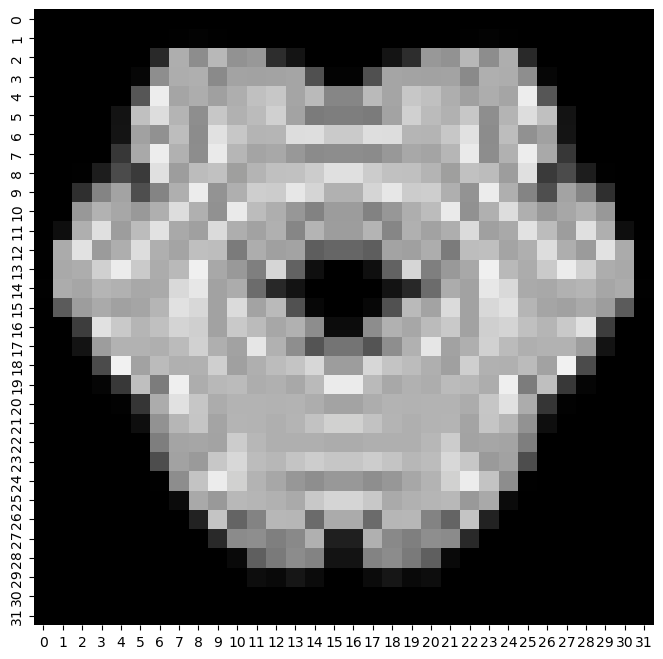

In [40]:
import seaborn as sns
cmap = sns.color_palette("light:k_r", as_cmap=True)

rv = np.reshape(np.loadtxt("r32.txt"), (32, 32)).T
rv /= rv.max()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(rv, cmap=cmap, cbar=False,ax=ax)
# for c in 

In [139]:
np.savetxt('r64.txt', rv)

In [56]:
sum([ot.emd2(r, c[:,i], W) for i in range(c.shape[1])])

tensor(0.1565, device='cuda:0', dtype=torch.float64)